# Chapter 24. 단조관계 (monotonic relationships) 측정


* 단조관계(Monotonic relationships)

    하나의 변수가 증가하면 다른 하나도 증가. 혹은, 감소하면 다른 하나도 감소
---
스페어만순위상관계수(Spearman Rank Correlation Coefficient) 는 두개의 data series 가 함께 움직이는지 여부를 결정하도록 해준다. 즉, 하나가 증가 (감소) 할 때, 다른 쪽도 증가 (감소)

이것은 선형뿐 아니라 비선형을 포함한 상관 관계를 결정. 예를 들어 $y = e^x$ 는 단조함수 (monotonic function) 이지만 선형은 아니다. 따라서, 계산시에는 raw data 가 아니라 data 의 순위를 비교한다. 

이 것은 data 의 단위가 달라서 선형으로 관련되지 않은 경우 유용하다. (예, 정방형표본지(square plot) 의 가격과 옆길이의 관계. 왜냐하면 가격은 면적과 선형 관계이기 때문이다.) 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [2]:
# Example of ranking data
l = [10, 9, 5, 7, 5]
print('Raw data: ', l)
# actual data 대신 dataset 에서 data 의 position 으로 변환
print('Ranking: ', list(stats.rankdata(l, method='average')))   

Raw data:  [10, 9, 5, 7, 5]
Ranking:  [5.0, 4.0, 1.5, 3.0, 1.5]


위 경우 5 가 2 개 있어서 동률이므로 method average 를 적용하여 (1+2) / 2 = 1.5 로 rank 부여. 이렇게 하면 outlier data 값이 ranking 으로 쪼그라들어 영향이 줄어든다. 예를 들어 10 대신 1,000,000 이 들어가도 5.0 으로 변환된다.

이러한 방법으로 이상한 outlier 가 들어가도 두 변수의 relationship 을 찾기 쉽게 된다.

## 스페어만 순위 상관관계 (Spearman Rank Correlation)

### 개념

두 변수간의 관계를 찾는 대신에 둘 간의 순위의 관계를 찾는다. 이 방법은 이상점(outlier) 이나 data 의 scale 문제를 쉽게 해결해 준다. 

### 정의

`method='average'` 는 동률이 생길 경우 평균 순위를 부여하는 것. 

Spearman rank correlation 은 $X$ 와 $Y$ 두 data set 에 대해 , 각각의 크기가 $n$ 이라 하면, 다음 공식을 사용하여 계산한다.

$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

여기서 $d_i$ 는 $i$ 번째 관측 쌍의 순위간의 차이 즉,  $X_i - Y_i$ 이다.

이 결과는 언제나 -1 과 1 사이이다. 양수는 양의 관계, 음수는 역의 관계를 나타낸다. 0 는 단조 관계 없음을 나타낸다. 그러나 이 것이 관계가 없음을 의미하지는 않는데, 예를 들어 Y 가 2 만큼 지연되어 X 와 같아지는 경우 둘 사이의 관계는 분명히 있지만 $r_S$ 는 0 에 가까울 수 있다.

## 실험

correlation 이 존재하는 비정규분포의 toy dataset X, Y 를 만들고, 위의 Spearman rank correlation 과 normal correlation 중 어떤 것이 더 correlation 관계를 정확히 나타내는지 비교해 본다.

X 가 포아송분포 (비 정규)일때, $Y = e^X + \epsilon$ 로 correlation 관계를 만든다. 여기서 $\epsilon$ 은 또다른 포아송분포에서 가져옴.

이 data 에 스페어만 순위와 상관계수를 취하고 전체 실험을 여러번 수행한다. $e^X$ 가 여러 이상점(outlier) 를 만들 것이므로 스페어만 순위가 이상점들을 압축하여 상관관계 측정이 더 용이하도록 할 것이다. 정규 상관관계는 이상점들로 인해 혼란스러워지고 평균적으로 실제보다 적은 relation 이 측정될 것이다.

* 참고 : Poisson 분포와 정규분포의 차이점

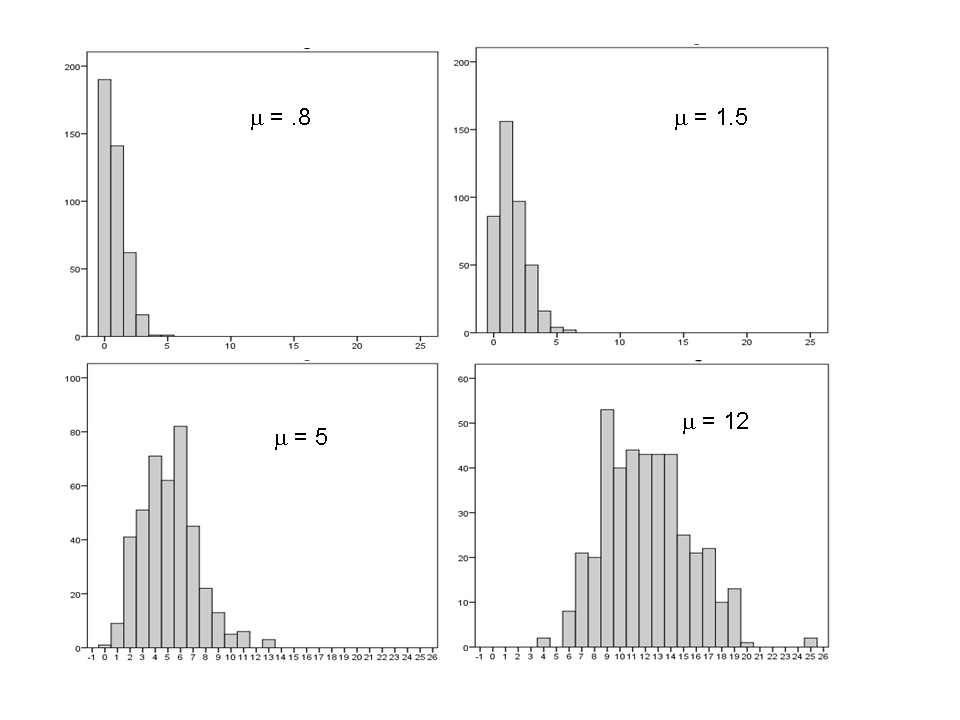

For example, a Poisson distribution with a low mean is highly skewed, with 0 as the mode. All the data are “pushed” up against 0, with a tail extending to the right. You can see an example in the upper left quadrant above.

But if the mean is larger, the distribution spreads out and becomes more symmetric. In fact, with a mean as high as 12, the distribution looks downright normal.

A Poisson distribution with a high enough mean approximates a normal distribution, even though technically, it is not.

One difference is that in the Poisson distribution the variance = the mean. In a normal distribution, these are two separate parameters. The value of one tells you nothing about the other.

So a Poisson distributed variable may look normal, but it won’t quite behave the same.


In [3]:
## Let's see an example of this
n = 100
noise = 1.0

def compare_correlation_and_spearman_rank(n, noise):
    X = np.random.poisson(size=n)
    Y = np.exp(X) + noise * np.random.normal(size=n)

    Xrank = stats.rankdata(X, method='average')
    # n-2 is the second to last element
    Yrank = stats.rankdata(Y, method='average')

    diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
    r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))     # Spearman rank correlation
    c_c = np.corrcoef(X, Y)[0,1]                           #  normal correlation      
    
    return r_s, c_c

experiments = 10000
spearman_dist = np.ndarray(experiments)
correlation_dist = np.ndarray(experiments)
for i in range(experiments):
    r_s, c_c = compare_correlation_and_spearman_rank(n, noise)
    spearman_dist[i] = r_s
    correlation_dist[i] = c_c
    
print('Spearman Rank Coefficient: ' + str(np.mean(spearman_dist)))
# Compare to the regular correlation coefficient
print('Correlation coefficient: ' + str(np.mean(correlation_dist)))

Spearman Rank Coefficient: 0.876737121212
Correlation coefficient: 0.772395784235


위에서 측정된 상관계수의 분포를 정규와 스페어만 간에 비교해 보면, normal correlation 의 histogram 은 이상한 모습을 보이며 넓게 퍼져 있는데 반하여 스페어만 correlation coefficient 의 histogram 은 robust 한 모습을 보이고 있다. mean 도 0.8 과 0.9 부근에서 형성되었다.

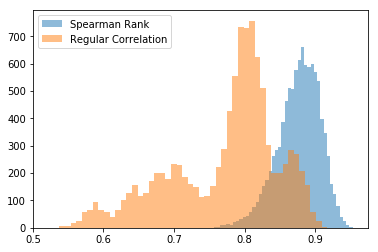

In [4]:
plt.hist(spearman_dist, bins=50, alpha=0.5)
plt.hist(correlation_dist, bins=50, alpha=0.5)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel;

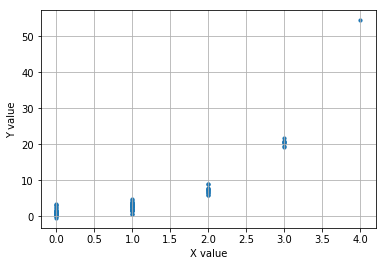

In [5]:
X = np.random.poisson(size=n)
Y = np.exp(X) + noise * np.random.normal(size=n)
plt.scatter(X, Y, s=10)
plt.grid(True)
plt.xlabel('X value')
plt.ylabel('Y value');

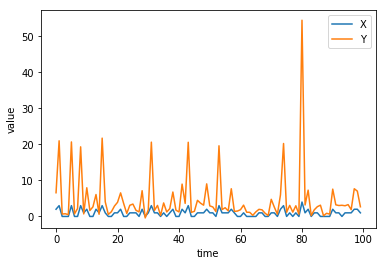

In [6]:
plt.plot(X)
plt.plot(Y)
plt.legend(['X', 'Y'])
plt.xlabel('time')
plt.ylabel('value');

좀 더 많은 noise 를 추가할 때 스페어만 순위와 정규 계수가 어떻게 영향 받는지를 테스트해 본다.

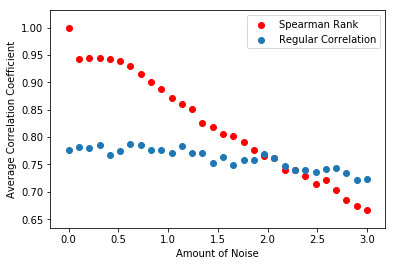

In [7]:
n = 100
noises = np.linspace(0, 3, 30)
experiments = 100
spearman = np.ndarray(len(noises))
correlation = np.ndarray(len(noises))

for i in range(len(noises)):
    # Run many experiments for each noise setting
    rank_coef = 0.0
    corr_coef = 0.0
    noise = noises[i]
    for j in range(experiments):
        r_s, c_c = compare_correlation_and_spearman_rank(n, noise)
        rank_coef += r_s
        corr_coef += c_c
    spearman[i] = rank_coef/experiments
    correlation[i] = corr_coef/experiments
    
plt.scatter(noises, spearman, color='r')
plt.scatter(noises, correlation)
plt.legend(['Spearman Rank', 'Regular Correlation'])
plt.xlabel('Amount of Noise')
plt.ylabel('Average Correlation Coefficient');

위에서 보듯이 비선형 관계에 대한 스페어만 순위 상관관계는 대부분의 noise 수준에서 normal 상관관계보다 더 나은 결과를 보인다. 재미있는 것은 noise 가 아주 높은 수준으로 올라가면 regular correlation 보다 더 나쁜 결과를 보이는 것이다.

## 상관관계의 지연 (Delay in correlation)

일정 시간 지연 후에 영향을 미치는 상관관계 파악.

In [8]:
n = 100

X = np.random.rand(n)
Xrank = stats.rankdata(X, method='average')
# n-2 is the second to last element
Yrank = stats.rankdata([1,1] + list(X[:(n-2)]), method='average')

diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
print(r_s)

-0.0070597059706


위에서 두 변수간 관계는 전혀 감지되지 않았다. 정규 혹은 스페어만 관계를 check 할 때에 data 를 offsetting 하여 offset value 간의 지연관계를 test 하는 것이 중요하다.

## Built-In Function

`scipy.stats` library 에서 제공하는 `spearmanr` 함수를 사용하면 p-value 도 함께 주어진다. 아래의 경우 p-value 가 0.05 보다 크므로 아래의 스페어만 계수는 무의미한 것으로 간주된다.

In [9]:
# Generate two random data sets
np.random.seed(161)
X = np.random.rand(10)
Y = np.random.rand(10)

r_s = stats.spearmanr(X, Y)
print( 'Spearman Rank Coefficient: ', r_s[0])
print('p-value: ', r_s[1])

Spearman Rank Coefficient:  0.236363636364
p-value:  0.510885317515


스페어만 상관계수 $r_S$ 를 구하고 나서 어떻게 이해할 것인가 ? 양수인 경우 서로 반대 관계는 아니라는 것 정도는 알겠지만 얼마나 상관 관계가 크게 있는지 그냥 보아서 판정하기는 쉽지 않다. 다행히 스페어만 함수는 sample 크기에 대한 p-value 를 계산해 주므로 p-value 가 0.05 보다 크면 우리는 X 와 Y 가 상관 되었다고 주장할 수 없다.

## 실제 사례: Mutual Fund Expense Ratio

스페어만 순위 상관관계가 작동하는 원리를 알았으므로 실제 사례에 적용해 보자. 예를 들어, mutual fund 의 비용율이 3 년 Sharpe ratio 지표가 되는가 하는 것이다. 즉, 관리에 돈을 더 사용하면 risk 를 낮추고 수익을 증가시키는가 ? 관리보수를 많이 떼어가는 비싼 펀드가 더 높은 Sharpe ratio 를 보이는지 Yahoo Finance data 로 test 해 본다.

Spearman Rank Coefficient:  -0.369696969697
p-value:  0.293050075293


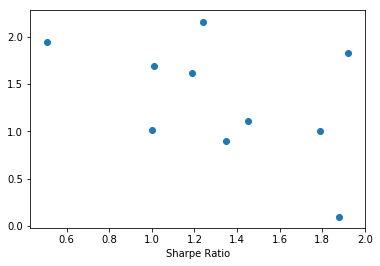

In [10]:
# Copying data for DXHLX, UGPIX, ALQIX, IIRFX, TMSCX, FHKCX, MCDFX, NRICX, PINHX, ANGLX
expense = [1.35, 1.79, 1.45, 1.88, 1., 1.01, 1.19, 1.92, 0.51, 1.24]
sharpe = [0.9, 1., 1.11, 0.1, 1.01, 1.69, 1.62, 1.83, 1.94, 2.16]

plt.scatter(expense, sharpe)
plt.xlabel('Expense Ratio')
plt.xlabel('Sharpe Ratio')

r_S = stats.spearmanr(expense, sharpe)
print('Spearman Rank Coefficient: ', r_S[0])
print('p-value: ', r_S[1])

위의 결과만으로는 비용율과 Sharpe ratio 는 실제로 반대의 상관관계를 갖는다. 하지만 p-value 가 0.05 보다 크므로 유의미하다고 간주하지 않는다.

## 실제 사례 : Ranking 모델 평가 

주식종목들에 대해 순위를 부여하여 상위 10 % 는 buy 를 하고 하위 10% 는 sell 을 하는 long-short strategy 를 구사한다고 가정하고, 이러한 순위 전략이 meaningful 한지 test 하는데 사용 할 수 있다.

여기서는 지난달의 일일 수익을 가지고 주식별 순위를 정하는 model 을 테스트해 본다.

가설은 지난달 수익으로 다음달의 평균 수익을 예측할 수 있다는 것이다. 이를 테스트 하기위해 지난 1 달의 주식에 점수를 매기고, 그 score 와 앞으로 한달의 평균 수익 대한 스페어만 순위 상관관계를 구한다.

In [11]:
symbol_list = ['AAPL', 'ABC', 'ABBV', 'ACE', 'AGN', 'ADP', 'ADSK','ABT', 'AEE','ACN','AEP','ADBE','AET',
                      'ADI','ADM','ADS','AIV','ADT','ALL','AES','ALTR','ALXN','AFL','MAT','AIG','AMGN','AIZ']

import pandas as pd
import quandl
quandl.ApiConfig.api_key = 'U_Gp39gZutpHmaFgC65Y' 

start = '2014-12-01'
end = '2015-01-01'

historical_returns = pd.DataFrame()
for symbol in symbol_list:
    data = quandl.get('WIKI/' + symbol, start_date=start, end_date=end)['Adj. Close']
    historical_returns[symbol] = data

In [12]:
# Compute our stock score
scores = np.mean(historical_returns)
print('Our Scores\n')
print(scores)
print('\n')

Our Scores

AAPL    106.790834
ABC      87.303634
ABBV     60.451713
ACE     111.933782
AGN     259.030405
ADP      79.393468
ADSK     59.862045
ABT      42.114239
AEE      39.919436
ACN      81.930748
AEP      53.386054
ADBE     73.270682
AET      86.243560
ADI      52.276644
ADM      47.776866
ADS     280.859322
AIV      34.070624
ADT      32.772627
ALL      65.730590
AES      12.117486
ALTR     36.896758
ALXN    189.635000
AFL      56.248769
MAT      26.256535
AIG      52.482721
AMGN    154.185020
AIZ      64.131424
dtype: float64




In [13]:
start = '2015-01-01'
end = '2015-02-01'

walk_forward_returns = pd.DataFrame()
for symbol in symbol_list:
    data = quandl.get('WIKI/' + symbol, start_date=start, end_date=end)['Adj. Close']
    walk_forward_returns[symbol] = data

walk_forward_returns = np.mean(walk_forward_returns)
print('The Walk Forward Returns\n')
print(walk_forward_returns)
print('\n')

The Walk Forward Returns

AAPL    105.109888
ABC      88.791257
ABBV     57.676994
ACE     109.026338
AGN     267.264479
ADP      79.178007
ADSK     57.159250
ABT      41.713243
AEE      41.097641
ACN      82.834676
AEP      56.342898
ADBE     71.561250
AET      89.047167
ADI      50.260027
ADM      44.395170
ADS     286.392076
AIV      36.403677
ADT      33.549284
ALL      66.850482
AES      11.544459
ALTR     34.491017
ALXN    181.607500
AFL      54.732491
MAT      24.333525
AIG      49.338104
AMGN    146.634303
AIZ      61.646149
dtype: float64




Correlation Coefficient: 0.997557997558
p-value: 2.00761273507e-30


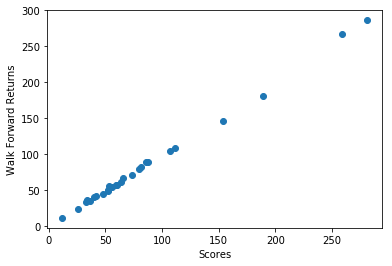

In [14]:
plt.scatter(scores, walk_forward_returns)
plt.xlabel('Scores')
plt.ylabel('Walk Forward Returns')

r_s = stats.spearmanr(scores, walk_forward_returns)
print('Correlation Coefficient: ' + str(r_s[0]))
print('p-value: ' + str(r_s[1]))

p-value 가 0.05 보다 작으므로 우리의 가설은 true 이고 우리의 ranking 이 random 보다 낫지 않다는 null 가설은 reject 된다. 이 것은 long-short 주식 포트폴리오 구성을 위한 ranking system check 에 매우 유용하다.